Scraping of Manga Title and Descriptions

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Function to scrape the description of a manga
def scrape_manga_description(manga_url):
    response = requests.get(manga_url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')

        # Try to locate the description using a different element or class
        description_elem = soup.find('div', {'class': 'panel-story-info-description'})

        if description_elem:
            description_text = description_elem.get_text().strip()
            return description_text

    return None


# Main function to scrape manga titles and descriptions from a page
def scrape_manga_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        manga_list = soup.find_all('a', {'class': 'genres-item-name'})

        data = []
        for manga in manga_list:
            title = manga['title']
            manga_url = manga['href']
            description = scrape_manga_description(manga_url)
            data.append({'Title': title, 'Description': description})

        return data
    return None

# URL of the first manga list page
base_url = 'https://manganato.com/genre-all?type=topview'

# Scrape manga data from multiple pages
total_titles = 0
page_number = 1
manga_data = []

while total_titles < 1000:
    page_url = f'{base_url}/{page_number}'
    page_data = scrape_manga_data(page_url)

    if page_data:
        manga_data.extend(page_data)
        total_titles += len(page_data)
        page_number += 1
    else:
        break

# Save the data to a CSV file
if manga_data:
    df = pd.DataFrame(manga_data)
    df.to_csv('manga_data.csv', index=False)
    print(f'Saved {len(manga_data)} titles to manga_data.csv')
else:
    print('Failed to scrape data.')



Saved 1008 titles to manga_data.csv


In [ ]:
print(manga_data)

[{'Title': 'Youjo Senki', 'Description': "Description :\nA young girl fights on the frontlines in war. She has blonde hair, blue eyes, and nearly transparent white skin, and she flies through the air and mercilessly strikes down her opponents. Her name is Tanya Degurechov, and she speaks with a young girl's lisp and commands the army. Tanya used to be one of Japan's elite office workers, but because of a wrathful god, was reborn as a little girl. Tanya prioritizes optimization and career advancement above all, and she will become the most dangerous entity among the Imperial Army's sorcerers."}, {'Title': 'The Dignity Of Romance', 'Description': 'Description :\nWhen corporate director Seo Woohyun goes on a blind date with journalist Lee Byul, love is not on his mind. Nonetheless, charmed by her eccentric personality, he soon finds himself in bed with her. But when Byul suddenly disappears, Woohyun tracks her down at an abandoned hotel that his company plans to develop. To his surprise, 

Topic Generation Based on the Manga Description Using LDA

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.metrics import silhouette_score
import numpy as np
import nltk

# Preprocessing----------------------------------------------------------------

# Download the NLTK words dataset
nltk.download('words')
nltk.download('stopwords')
english_words = set(words.words())

data = pd.read_csv("manga_data.csv")

# Remove rows with the Description "not found..."
data = data[data["Description"] != "Description : not found..."]

# Remove rows where the "Description" contains the string "summary is updating"
data = data[~data["Description"].str.contains("summary is updating")]

# Fill missing descriptions with an empty string
data['Description'].fillna('', inplace=True)

# Process only the "Description" column
descriptions = data["Description"]

# Define the string to remove
string_to_remove = "If you have any question about this manga, Please don't hesitate to contact us or translate team. Hope you enjoy it."

# Function to filter non-English words, remove "Description:", remove the specified string
stop_words = set(stopwords.words("english"))
def filter_english_words(text):
    # Remove "Description: " and any leading/trailing whitespace
    text = text.replace("Description : ", "").strip()
    text = text.replace("Description", "")

    # Remove the specified string
    text = text.replace(string_to_remove, "")

    words = text.split()
    english_words_only = [word for word in words if word.lower() in english_words and word.lower() not in stop_words]
    return ' '.join(english_words_only)

# Apply the filtering to descriptions
filtered_descriptions = descriptions.apply(filter_english_words)
# Remove empty rows
filtered_descriptions = filtered_descriptions[filtered_descriptions.str.strip() != ""]

# Function to create bigrams
def create_bigrams(text):
    words = text.split()
    bigram_tokens = [' '.join(gram) for gram in ngrams(words, 2)]
    return ' '.join(bigram_tokens + words)

# Apply the bigram creation to descriptions
filtered_descriptions = filtered_descriptions.apply(create_bigrams)

# Group shorter documents together(Balancing of Strings)
threshold_length = 50
grouped_documents = []

current_group = []
for document in filtered_descriptions:
    if len(document.split()) < threshold_length:  # Check if the document is short
        current_group.append(document)  # Add it to the current group
    else:
        if current_group:  # Check if the current group is not empty
            grouped_documents.append(" ".join(current_group))  # Add the current group to the grouped documents
        current_group = [document]  # Start a new group with the current document

if current_group:  # Check if there is a non-empty group remaining
    grouped_documents.append(" ".join(current_group))  # Add it to the grouped documents

# Output the preprocessed description into a CSV file
preprocessed_data = pd.DataFrame({'Description': grouped_documents})
preprocessed_data.to_csv('preprocessed_manga_data.csv', index=False)
# End of Preprocessing----------------------------------------------------------------

count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = count_vectorizer.fit_transform(grouped_documents)

dictionary = Dictionary([doc.split() for doc in grouped_documents])
corpus = [dictionary.doc2bow(doc.split()) for doc in grouped_documents]

num_topics = 3
best_silhouette_score = -1
best_coherence_score = -1
best_num_topics = 0

for num_topics in range(3, 11):
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, alpha='auto', eta='auto', random_state=42)

    # Compute the silhouette score
    topic_probabilities = lda_model.get_document_topics(corpus)
    topic_labels = [max(topic, key=lambda x: x[1])[0] for topic in topic_probabilities]  # Extract cluster labels

    silhouette_avg = silhouette_score(doc_term_matrix, topic_labels)

    # Compute the coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=[doc.split() for doc in grouped_documents], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    if silhouette_avg > best_silhouette_score and coherence_score > best_coherence_score:
        best_silhouette_score = silhouette_avg
        best_coherence_score = coherence_score
        best_num_topics = num_topics

lda_model = LdaModel(corpus, num_topics=best_num_topics, id2word=dictionary, passes=15, alpha='auto', eta='auto', random_state=42)

# Print the best silhouette score, coherence score, and number of topics
print(f"Best Number of Topics: {best_num_topics}")
print(f"Best Silhouette Score: {best_silhouette_score}")
print(f"Best Coherence Score: {best_coherence_score}")
# Calculate Perplexity
perplexity = lda_model.log_perplexity(corpus)
print(f"Perplexity: {perplexity}")
# Print the top words for each topic
for topic_id in range(best_num_topics):
    print(f"Topic {topic_id + 1}:")
    words = [word for word, prob in lda_model.show_topic(topic_id)]
    print(words)


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Best Number of Topics: 7
Best Silhouette Score: 0.4385826290359672
Best Coherence Score: 0.6143305013003344
Perplexity: -4.360572148846744
Topic 1:
['wedding', 'find', 'without', 'favorite', 'free', 'father', 'Tae', 'bride', 'character', 'ordinary']
Topic 2:
['Henry', 'become', 'magic', 'also', 'little', 'one', 'girl', 'Top', 'man', 'order']
Topic 3:
['become', 'powerful', 'first', 'story', 'whose', 'level', 'guild', 'like', 'Count', 'skill']
Topic 4:
['free', 'favorite', 'live', 'life', 'world', 'find', 'may', 'particularly', 'video', 'graphics']
Topic 5:
['favorite', 'free', 'daughter', 'Gris', 'first', 'would', 'latest', 'full', 'ordinary', 'manga']
Topic 6:
['sister', 'man', 'help', 'ever', 'idol', 'maid', 'think', 'mature', 'works', 'younger']
Topic 7:
['love', 'school', 'everything', 'Character', 'make', 'fall', 'high', 'starting', 'head', 'Never']


In [ ]:
# Save the LDA model
lda_model.save('lda_model')

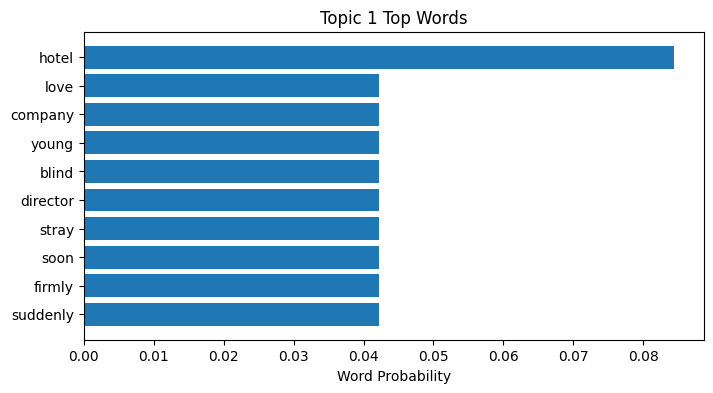

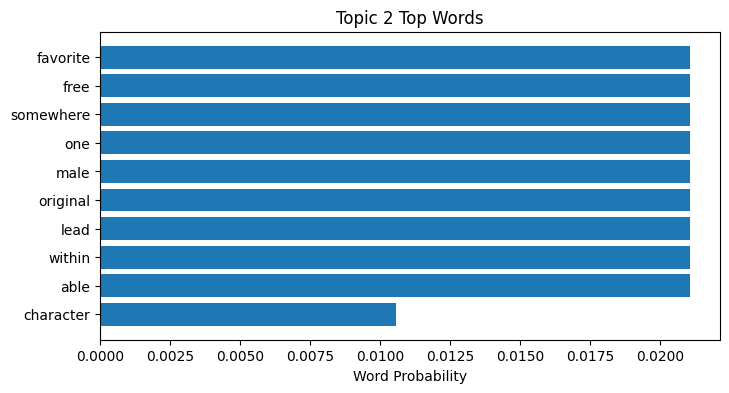

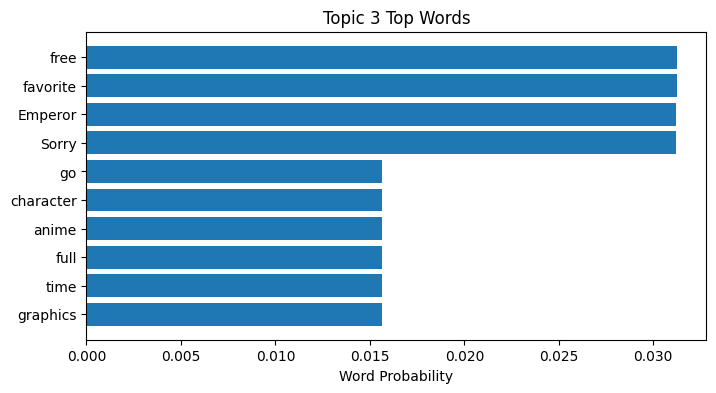

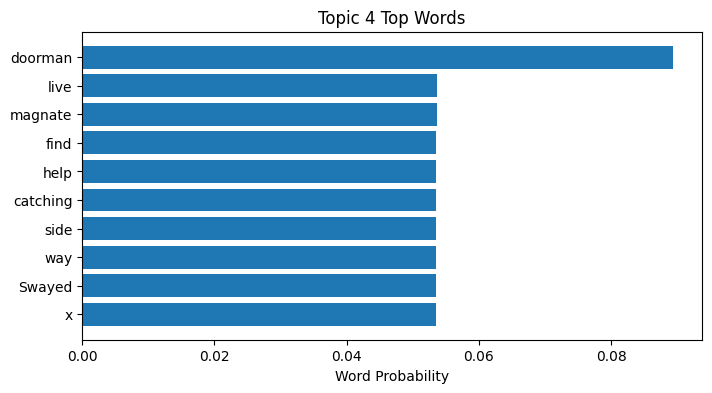

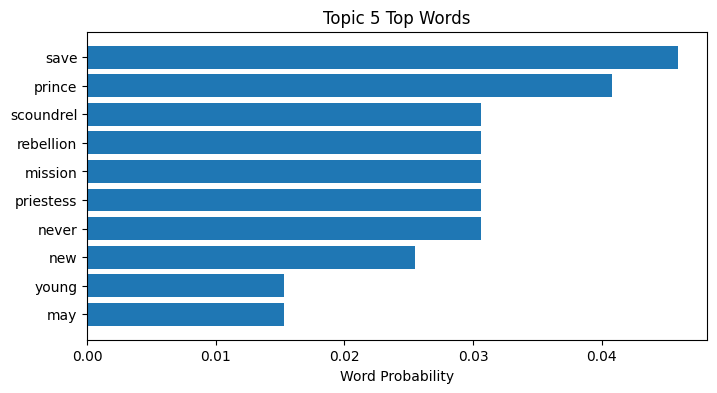

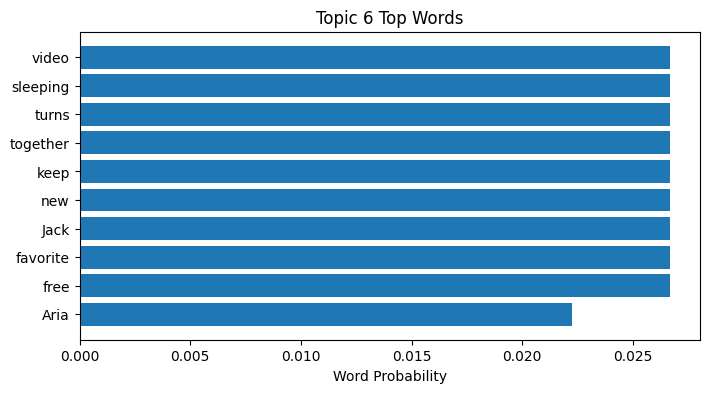

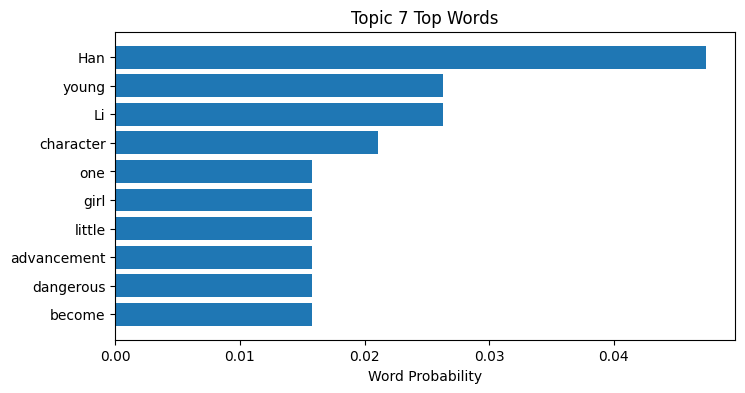

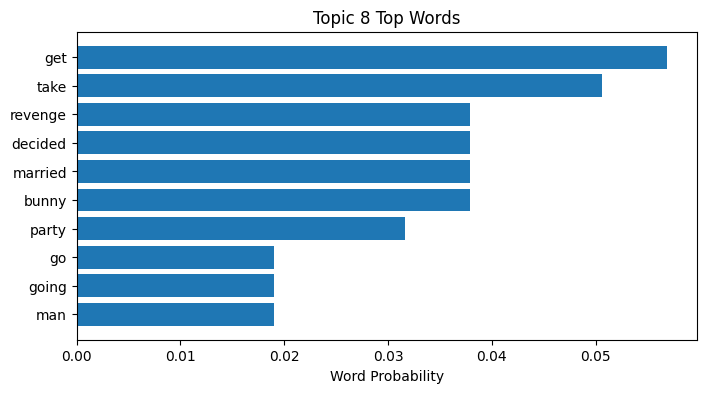

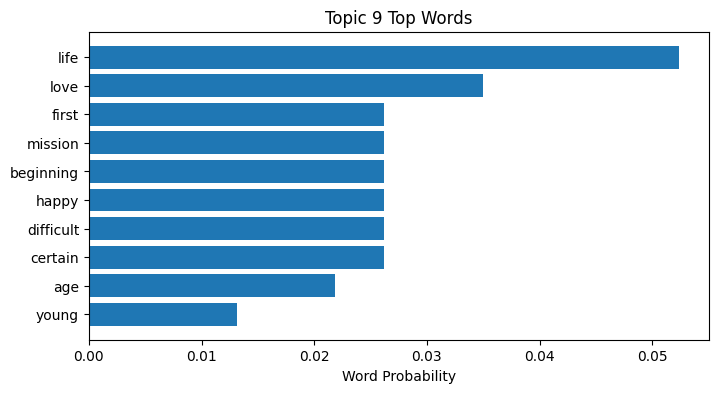

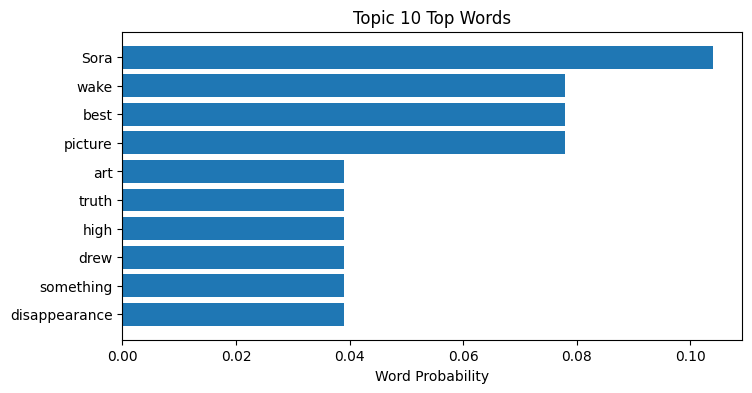

In [ ]:
import matplotlib.pyplot as plt

# Create bar charts for top words in each topic
for topic_id in range(best_num_topics):
    words = [word for word, prob in lda_model.show_topic(topic_id)]
    word_probs = [prob for word, prob in lda_model.show_topic(topic_id)]

    plt.figure(figsize=(8, 4))
    plt.barh(words, word_probs)
    plt.title(f'Topic {topic_id + 1} Top Words')
    plt.xlabel('Word Probability')
    plt.gca().invert_yaxis()
    plt.show()


In [ ]:
pip install --upgrade pyLDAvis joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 34.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicor

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Visualize the LDA model with PyLDAvis
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_model, corpus, dictionary, n_jobs=1)
pyLDAvis.display(vis_data)


TypeError: ignored

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load your dataset
data = pd.read_csv('preprocessed_manga_data.csv')

# Apply LDA or LSA for topic modeling (use gensim or scikit-learn)

# Feature engineering: Convert text data to TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
X = tfidf_vectorizer.fit_transform(data['Description'])

# Dimensionality reduction with Truncated SVD
lsa = TruncatedSVD(n_components=100)  # Adjust n_components as needed
X = lsa.fit_transform(X)

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, data['Description'], test_size=0.3, random_state=42)

# Initialize and train a classification model (e.g., Random Forest)
model = RandomForestClassifier()

# Evaluate the model using k-fold cross-validation
num_folds = 5  # You can adjust the number of folds as needed
cross_val_scores = cross_val_score(model, X, data['Description'], cv=num_folds, scoring='accuracy')

print(f'Cross-Validation Accuracy Scores: {cross_val_scores}')
print(f'Mean Accuracy: {cross_val_scores.mean() * 100:.2f}%')

# Train the model on the full training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model on the test data
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cross-Validation Accuracy Scores: [1. 1. 1. 1. 1.]
Mean Accuracy: 100.00%
Test Accuracy: 100.00%


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Load your dataset
data = pd.read_csv('preprocessed_manga_data.csv')

# Apply LDA or LSA for topic modeling (use gensim or scikit-learn)

# Feature engineering: Convert text data to TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
X = tfidf_vectorizer.fit_transform(data['Description'])

# Dimensionality reduction with Truncated SVD
lsa = TruncatedSVD(n_components=100)  # Adjust n_components as needed
X = lsa.fit_transform(X)

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, data['Description'], test_size=0.2, random_state=42)

# Initialize and train a classification model (e.g., Random Forest)
model = RandomForestClassifier(n_estimators=100, multi_class='ovr')  # or 'ovo'

# Evaluate the model using k-fold cross-validation
num_folds = 5  # You can adjust the number of folds as needed
cross_val_scores = cross_val_score(model, X, data['Description'], cv=num_folds, scoring='accuracy')

print(f'Cross-Validation Accuracy Scores: {cross_val_scores}')
print(f'Mean Accuracy: {cross_val_scores.mean() * 100:.2f}%')

# Train the model on the full training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate additional evaluation metrics
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print("Classification Report:\n", report)
print(f'ROC AUC: {roc_auc * 100:.2f}%')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: ignored